Customising MobilenetV2

In [1]:
!git clone https://github.com/coick4698/garbage_classification.git

from google.colab import drive
drive.mount('/content/drive')

%cd /content/garbage_classification

import sys
sys.path.append('/content/garbage_classification/src')

from dataset import get_dataloaders
from model import get_mobilenetv2
from train import train_model
from utils import plot_accuracy, plot_confusion_matrix

data_path = '/content/drive/MyDrive/iss_project/garbage_classification'

Cloning into 'garbage_classification'...
remote: Enumerating objects: 146, done.
remote: Counting objects: 100% (146/146), done.
remote: Compressing objects: 100% (122/122), done.
remote: Total 146 (delta 66), reused 32 (delta 5), pack-reused 0 (from 0)
Receiving objects: 100% (146/146), 1.74 MiB | 6.23 MiB/s, done.
Resolving deltas: 100% (66/66), done.
Mounted at /content/drive
/content/garbage_classification


Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 112MB/s] 


Epoch [1/10] Train Acc: 72.21%, Val Acc: 84.97%
Epoch [2/10] Train Acc: 82.24%, Val Acc: 86.21%
Epoch [3/10] Train Acc: 84.58%, Val Acc: 80.82%
Epoch [4/10] Train Acc: 87.59%, Val Acc: 85.51%
Epoch [5/10] Train Acc: 88.68%, Val Acc: 84.02%
Epoch [6/10] Train Acc: 89.85%, Val Acc: 87.91%
Epoch [7/10] Train Acc: 90.01%, Val Acc: 89.81%
Epoch [8/10] Train Acc: 90.85%, Val Acc: 85.11%
Epoch [9/10] Train Acc: 91.55%, Val Acc: 88.86%
Epoch [10/10] Train Acc: 92.96%, Val Acc: 89.11%


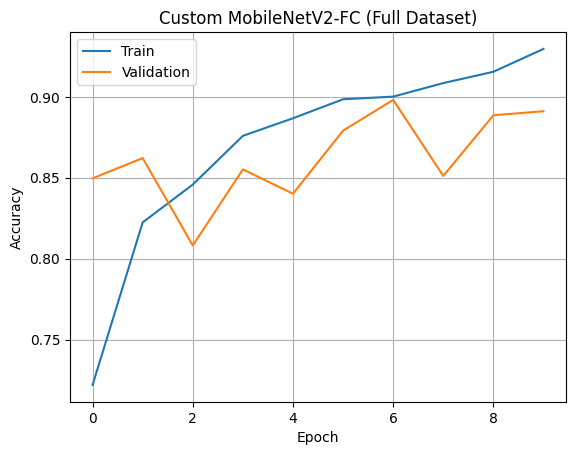

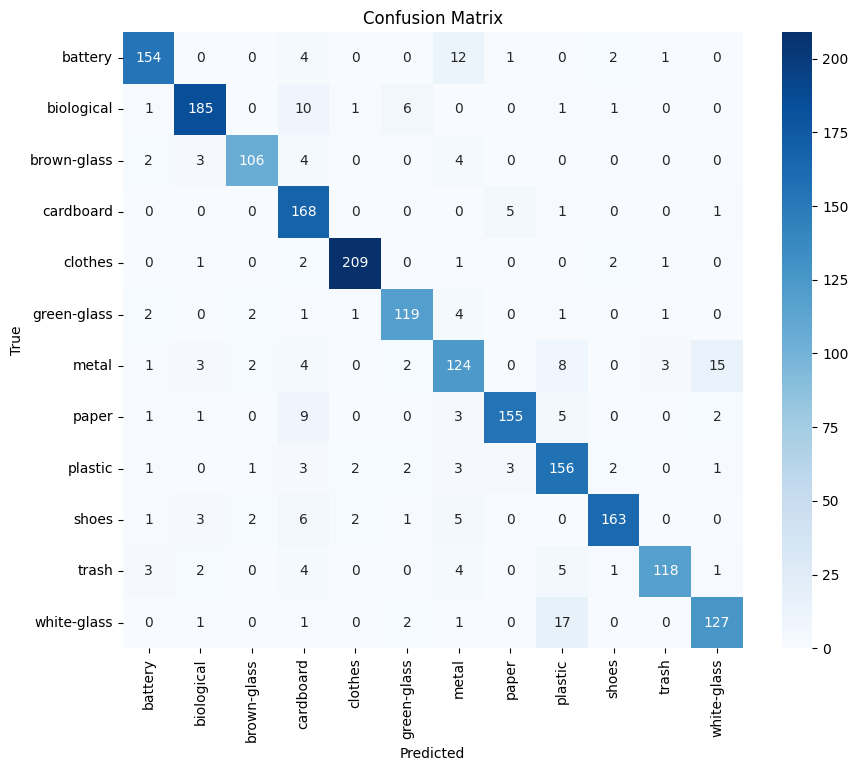

Classification Report:
              precision    recall  f1-score   support

     battery       0.93      0.89      0.91       174
  biological       0.93      0.90      0.92       205
 brown-glass       0.94      0.89      0.91       119
   cardboard       0.78      0.96      0.86       175
     clothes       0.97      0.97      0.97       216
 green-glass       0.90      0.91      0.90       131
       metal       0.77      0.77      0.77       162
       paper       0.95      0.88      0.91       176
     plastic       0.80      0.90      0.85       174
       shoes       0.95      0.89      0.92       183
       trash       0.95      0.86      0.90       138
 white-glass       0.86      0.85      0.86       149

    accuracy                           0.89      2002
   macro avg       0.89      0.89      0.89      2002
weighted avg       0.90      0.89      0.89      2002



In [ ]:
# Exp.1 - FC layer + Dropout + Activation Function
import torch
import torch.nn as nn
from torchvision.models import mobilenet_v2
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import cv2
import os

class CustomMobileNetV2_exp1(nn.Module):
    def __init__(self, num_classes=12):
        super(CustomMobileNetV2_exp1, self).__init__()
        base_model = mobilenet_v2(weights='IMAGENET1K_V1')
        self.features = base_model.features
        self.pool = nn.AdaptiveAvgPool2d(1)

        # 1280 -> 256 -> 12
        # Dropout(0.2,0.3)
        # Activation Function(ReLU6 -> GELU)
        self.classifier = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(1280, 256),
            nn.GELU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)

        )

    def forward(self, x):
        x = self.features(x)
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

# 2. load data
train_loader, val_loader, class_names = get_dataloaders(data_path, use_small=False)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 3. load model
model = CustomMobileNetV2_exp1(num_classes=12).to(device)
train_acc, val_acc = train_model(model, train_loader, val_loader, num_epochs=10, device=device)

# 4. Accuracy Plot
plot_accuracy(train_acc, val_acc, title="Custom MobileNetV2-Exp1 (Full Dataset)")

# 5. Confusion Matrix
plot_confusion_matrix(model, val_loader, class_names, device=device)

# 6. Precision / Recall / F1-score
all_preds, all_labels = [], []
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))

Epoch [1/10] Train Acc: 83.03%, Val Acc: 91.26%
Epoch [2/10] Train Acc: 91.01%, Val Acc: 91.56%
Epoch [3/10] Train Acc: 92.60%, Val Acc: 91.26%
Epoch [4/10] Train Acc: 94.01%, Val Acc: 93.01%
Epoch [5/10] Train Acc: 95.03%, Val Acc: 93.21%
Epoch [6/10] Train Acc: 95.38%, Val Acc: 93.96%
Epoch [7/10] Train Acc: 96.39%, Val Acc: 93.11%
Epoch [8/10] Train Acc: 96.55%, Val Acc: 94.51%
Epoch [9/10] Train Acc: 97.04%, Val Acc: 94.31%
Epoch [10/10] Train Acc: 96.74%, Val Acc: 93.96%


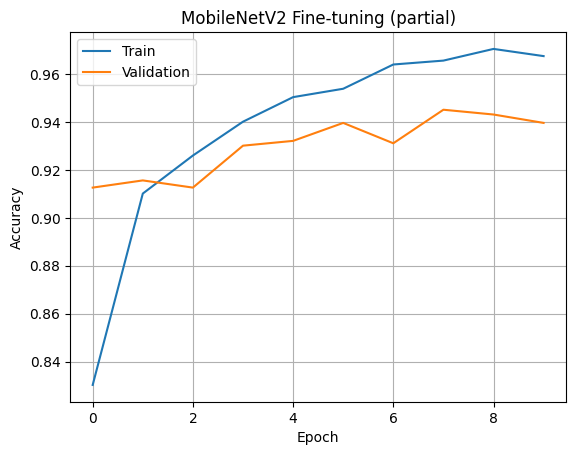

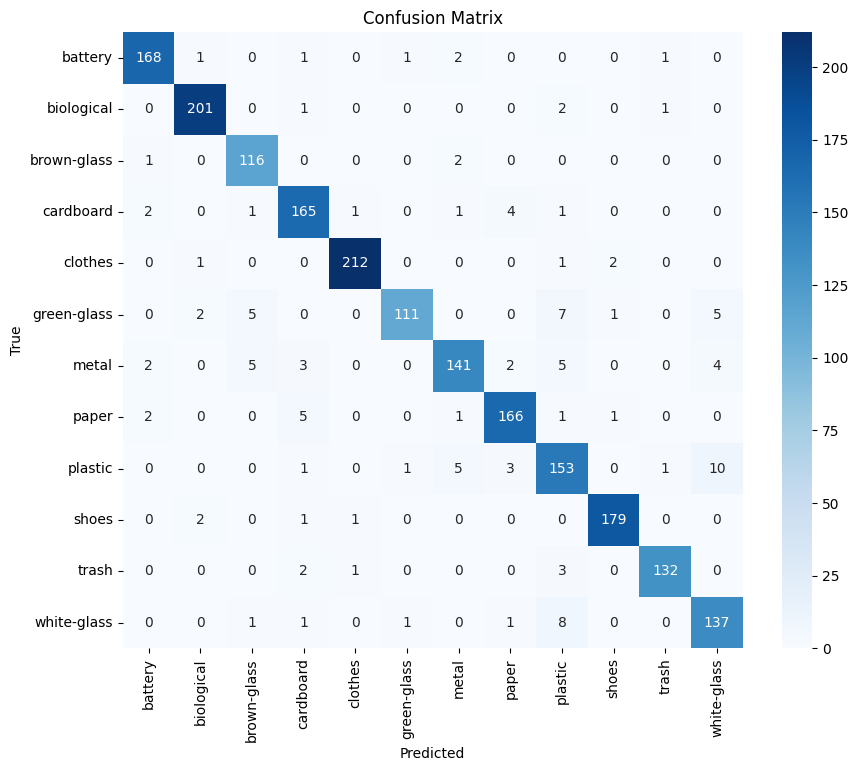

Classification Report:
              precision    recall  f1-score   support

     battery       0.96      0.97      0.96       174
  biological       0.97      0.98      0.98       205
 brown-glass       0.91      0.97      0.94       119
   cardboard       0.92      0.94      0.93       175
     clothes       0.99      0.98      0.98       216
 green-glass       0.97      0.85      0.91       131
       metal       0.93      0.87      0.90       162
       paper       0.94      0.94      0.94       176
     plastic       0.85      0.88      0.86       174
       shoes       0.98      0.98      0.98       183
       trash       0.98      0.96      0.97       138
 white-glass       0.88      0.92      0.90       149

    accuracy                           0.94      2002
   macro avg       0.94      0.94      0.94      2002
weighted avg       0.94      0.94      0.94      2002



In [ ]:
# Exp.2 - Transfer Learning Fine-tuning (partial)

import torch
import torch.nn as nn
from torchvision.models import mobilenet_v2, MobileNet_V2_Weights
from sklearn.metrics import classification_report

# 1) 모델 정의 (pretrained + custom head)
class CustomMobileNetV2_exp2(nn.Module):
    def __init__(self, num_classes=12):
        super().__init__()
        base = mobilenet_v2(weights=MobileNet_V2_Weights.IMAGENET1K_V1)
        self.features = base.features                      # pretrained backbone
        self.pool = nn.AdaptiveAvgPool2d(1)                # GAP

        # ✨ custom classifier head
        self.classifier = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(1280, 256),
            nn.GELU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x


# 2) 파인튜닝 범위 설정 유틸
def set_finetune_mode(model: CustomMobileNetV2_exp2, mode="partial", unfreeze_last_blocks=2):
    """
    mode: 'freeze' | 'partial' | 'full'
    - freeze  : backbone 전부 freeze (feature extractor만 사용, head만 학습)
    - partial : backbone의 마지막 N개 블록만 학습
    - full    : backbone 전부 학습
    """
    # 일단 전부 freeze
    for p in model.features.parameters():
        p.requires_grad = False

    if mode == "full":
        for p in model.features.parameters():
            p.requires_grad = True

    elif mode == "partial":
        # mobilenet_v2.features 는 Sequential. 마지막 N개 블록만 unfreeze
        blocks = list(model.features.children())
        for m in blocks[-unfreeze_last_blocks:]:
            for p in m.parameters():
                p.requires_grad = True

    elif mode == "freeze":
        pass  # 이미 전부 freeze 상태

    else:
        raise ValueError("mode should be one of {'freeze','partial','full'}")


# 3) 옵티마이저: 백본/헤드에 서로 다른 LR
def build_optimizer(model, backbone_lr=1e-4, head_lr=1e-3, weight_decay=1e-4):
    backbone_params = [p for p in model.features.parameters() if p.requires_grad]
    head_params     = [p for p in model.classifier.parameters() if p.requires_grad]

    param_groups = []
    if len(backbone_params) > 0:
        param_groups.append({"params": backbone_params, "lr": backbone_lr})
    if len(head_params) > 0:
        param_groups.append({"params": head_params, "lr": head_lr})

    # AdamW 권장
    optimizer = torch.optim.AdamW(param_groups, weight_decay=weight_decay)
    return optimizer


# -----------------------------
# 4) 실제 실험 스크립트
# -----------------------------
# (1) 데이터
train_loader, val_loader, class_names = get_dataloaders(data_path, use_small=False)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# (2) 모델
model = CustomMobileNetV2_exp2(num_classes=12).to(device)

# (3) 파인튜닝 모드 선택
#   'freeze'  : feature extraction만
#   'partial' : 마지막 2개 블록만 학습 (epoch 10 조건에서 강추)
#   'full'    : 전체 학습
finetune_mode = "partial"   # ← 실험마다 'freeze' / 'partial' / 'full' 바꿔서 비교
set_finetune_mode(model, mode=finetune_mode, unfreeze_last_blocks=2)

# (4) 옵티마이저 (백본/헤드 LR 분리)
optimizer = build_optimizer(
    model,
    backbone_lr=1e-4 if finetune_mode != "freeze" else 0.0,  # freeze면 사실상 의미 없음
    head_lr=1e-3,
    weight_decay=1e-4
)

# (5) 손실함수
criterion = nn.CrossEntropyLoss()

# (6) 학습 (네가 쓰는 train_model에 optimizer/criterion 인자만 추가해줘)
train_acc, val_acc = train_model(
    model,
    train_loader,
    val_loader,
    num_epochs=10,
    device=device
)

# (7) Plot & Report
plot_accuracy(train_acc, val_acc, title=f"MobileNetV2 Fine-tuning ({finetune_mode})")

plot_confusion_matrix(model, val_loader, class_names, device=device)

all_preds, all_labels = [], []
model.eval()
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))


Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 15.6MB/s]


Epoch [1/10] Train Acc: 72.53%, Val Acc: 84.96%
Epoch [2/10] Train Acc: 87.36%, Val Acc: 85.71%
Epoch [3/10] Train Acc: 92.12%, Val Acc: 89.47%
Epoch [4/10] Train Acc: 92.87%, Val Acc: 87.22%
Epoch [5/10] Train Acc: 95.06%, Val Acc: 88.22%
Epoch [6/10] Train Acc: 95.06%, Val Acc: 90.23%
Epoch [7/10] Train Acc: 97.06%, Val Acc: 87.22%
Epoch [8/10] Train Acc: 97.56%, Val Acc: 85.21%
Epoch [9/10] Train Acc: 97.31%, Val Acc: 88.22%
Epoch [10/10] Train Acc: 96.43%, Val Acc: 86.97%


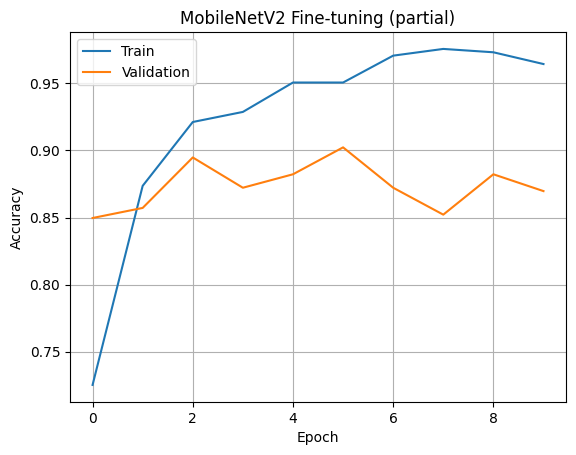

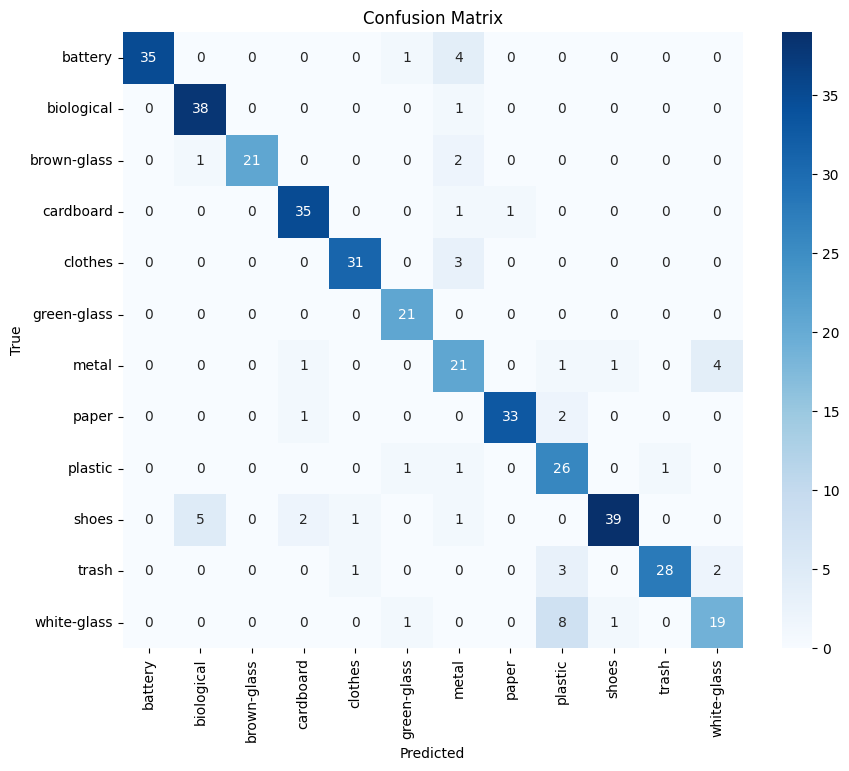

Classification Report:
              precision    recall  f1-score   support

     battery       1.00      0.88      0.93        40
  biological       0.86      0.97      0.92        39
 brown-glass       1.00      0.88      0.93        24
   cardboard       0.90      0.95      0.92        37
     clothes       0.94      0.91      0.93        34
 green-glass       0.88      1.00      0.93        21
       metal       0.62      0.75      0.68        28
       paper       0.97      0.92      0.94        36
     plastic       0.65      0.90      0.75        29
       shoes       0.95      0.81      0.88        48
       trash       0.97      0.82      0.89        34
 white-glass       0.76      0.66      0.70        29

    accuracy                           0.87       399
   macro avg       0.87      0.87      0.87       399
weighted avg       0.88      0.87      0.87       399



In [2]:
# Exp.2.5 - Transfer Learning Fine-tuning (partial) - small dataset

import torch
import torch.nn as nn
from torchvision.models import mobilenet_v2, MobileNet_V2_Weights
from sklearn.metrics import classification_report

# 1) 모델 정의 (pretrained + custom head)
class CustomMobileNetV2_exp2(nn.Module):
    def __init__(self, num_classes=12):
        super().__init__()
        base = mobilenet_v2(weights=MobileNet_V2_Weights.IMAGENET1K_V1)
        self.features = base.features                      # pretrained backbone
        self.pool = nn.AdaptiveAvgPool2d(1)                # GAP

        # ✨ custom classifier head
        self.classifier = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(1280, 256),
            nn.GELU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x


# 2) 파인튜닝 범위 설정 유틸
def set_finetune_mode(model: CustomMobileNetV2_exp2, mode="partial", unfreeze_last_blocks=2):
    """
    mode: 'freeze' | 'partial' | 'full'
    - freeze  : backbone 전부 freeze (feature extractor만 사용, head만 학습)
    - partial : backbone의 마지막 N개 블록만 학습
    - full    : backbone 전부 학습
    """
    # 일단 전부 freeze
    for p in model.features.parameters():
        p.requires_grad = False

    if mode == "full":
        for p in model.features.parameters():
            p.requires_grad = True

    elif mode == "partial":
        # mobilenet_v2.features 는 Sequential. 마지막 N개 블록만 unfreeze
        blocks = list(model.features.children())
        for m in blocks[-unfreeze_last_blocks:]:
            for p in m.parameters():
                p.requires_grad = True

    elif mode == "freeze":
        pass  # 이미 전부 freeze 상태

    else:
        raise ValueError("mode should be one of {'freeze','partial','full'}")


# 3) 옵티마이저: 백본/헤드에 서로 다른 LR
def build_optimizer(model, backbone_lr=1e-4, head_lr=1e-3, weight_decay=1e-4):
    backbone_params = [p for p in model.features.parameters() if p.requires_grad]
    head_params     = [p for p in model.classifier.parameters() if p.requires_grad]

    param_groups = []
    if len(backbone_params) > 0:
        param_groups.append({"params": backbone_params, "lr": backbone_lr})
    if len(head_params) > 0:
        param_groups.append({"params": head_params, "lr": head_lr})

    # AdamW 권장
    optimizer = torch.optim.AdamW(param_groups, weight_decay=weight_decay)
    return optimizer


# -----------------------------
# 4) 실제 실험 스크립트
# -----------------------------
# (1) 데이터
train_loader, val_loader, class_names = get_dataloaders(data_path, use_small=True)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# (2) 모델
model = CustomMobileNetV2_exp2(num_classes=12).to(device)

# (3) 파인튜닝 모드 선택
#   'freeze'  : feature extraction만
#   'partial' : 마지막 2개 블록만 학습 (epoch 10 조건에서 강추)
#   'full'    : 전체 학습
finetune_mode = "partial"   # ← 실험마다 'freeze' / 'partial' / 'full' 바꿔서 비교
set_finetune_mode(model, mode=finetune_mode, unfreeze_last_blocks=2)

# (4) 옵티마이저 (백본/헤드 LR 분리)
optimizer = build_optimizer(
    model,
    backbone_lr=1e-4 if finetune_mode != "freeze" else 0.0,  # freeze면 사실상 의미 없음
    head_lr=1e-3,
    weight_decay=1e-4
)

# (5) 손실함수
criterion = nn.CrossEntropyLoss()

# (6) 학습 (네가 쓰는 train_model에 optimizer/criterion 인자만 추가해줘)
train_acc, val_acc = train_model(
    model,
    train_loader,
    val_loader,
    num_epochs=10,
    device=device
)

# (7) Plot & Report
plot_accuracy(train_acc, val_acc, title=f"MobileNetV2 Fine-tuning ({finetune_mode})")

plot_confusion_matrix(model, val_loader, class_names, device=device)

all_preds, all_labels = [], []
model.eval()
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))


Epoch [1/10] Train Acc: 72.28%, Val Acc: 76.12%
Epoch [2/10] Train Acc: 82.15%, Val Acc: 85.46%
Epoch [3/10] Train Acc: 85.58%, Val Acc: 86.01%
Epoch [4/10] Train Acc: 86.22%, Val Acc: 89.41%
Epoch [5/10] Train Acc: 89.10%, Val Acc: 86.51%
Epoch [6/10] Train Acc: 89.59%, Val Acc: 83.62%
Epoch [7/10] Train Acc: 90.02%, Val Acc: 88.66%
Epoch [8/10] Train Acc: 91.96%, Val Acc: 87.26%
Epoch [9/10] Train Acc: 92.33%, Val Acc: 86.31%
Epoch [10/10] Train Acc: 92.18%, Val Acc: 88.76%


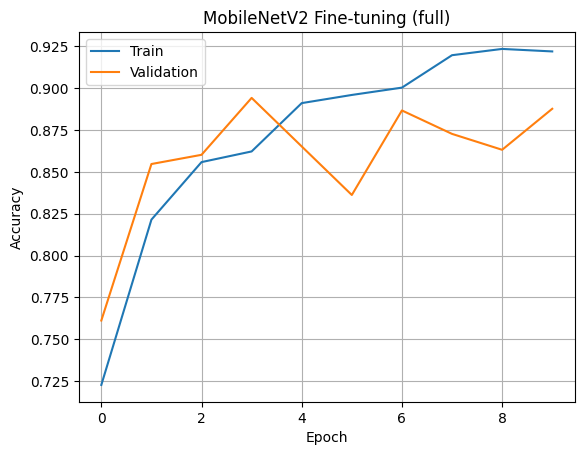

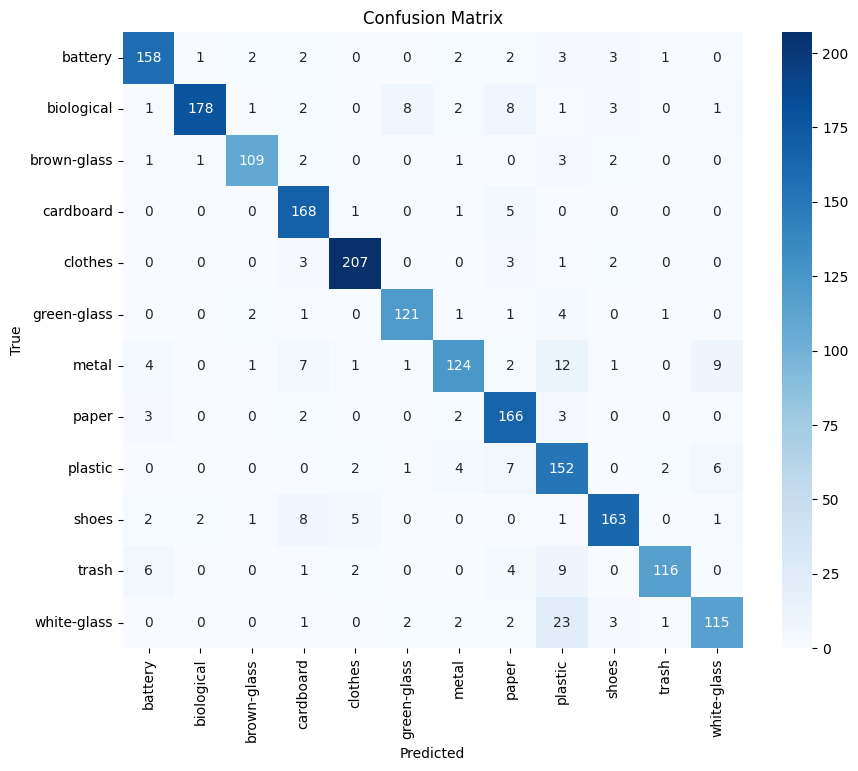

Classification Report:
              precision    recall  f1-score   support

     battery       0.90      0.91      0.91       174
  biological       0.98      0.87      0.92       205
 brown-glass       0.94      0.92      0.93       119
   cardboard       0.85      0.96      0.90       175
     clothes       0.95      0.96      0.95       216
 green-glass       0.91      0.92      0.92       131
       metal       0.89      0.77      0.82       162
       paper       0.83      0.94      0.88       176
     plastic       0.72      0.87      0.79       174
       shoes       0.92      0.89      0.91       183
       trash       0.96      0.84      0.90       138
 white-glass       0.87      0.77      0.82       149

    accuracy                           0.89      2002
   macro avg       0.89      0.88      0.89      2002
weighted avg       0.89      0.89      0.89      2002



In [3]:
# Exp.3 - Transfer Learning Fine-tuning (full)

import torch
import torch.nn as nn
from torchvision.models import mobilenet_v2, MobileNet_V2_Weights
from sklearn.metrics import classification_report

# 1) 모델 정의 (pretrained + custom head)
class CustomMobileNetV2_exp3(nn.Module):
    def __init__(self, num_classes=12):
        super().__init__()
        base = mobilenet_v2(weights=MobileNet_V2_Weights.IMAGENET1K_V1)
        self.features = base.features                      # pretrained backbone
        self.pool = nn.AdaptiveAvgPool2d(1)                # GAP

        # ✨ custom classifier head
        self.classifier = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(1280, 256),
            nn.GELU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x


# 2) 파인튜닝 범위 설정 유틸
def set_finetune_mode(model: CustomMobileNetV2_exp3, mode="partial", unfreeze_last_blocks=2):
    """
    mode: 'freeze' | 'partial' | 'full'
    - freeze  : backbone 전부 freeze (feature extractor만 사용, head만 학습)
    - partial : backbone의 마지막 N개 블록만 학습
    - full    : backbone 전부 학습
    """
    # 일단 전부 freeze
    for p in model.features.parameters():
        p.requires_grad = False

    if mode == "full":
        for p in model.features.parameters():
            p.requires_grad = True

    elif mode == "partial":
        # mobilenet_v2.features 는 Sequential. 마지막 N개 블록만 unfreeze
        blocks = list(model.features.children())
        for m in blocks[-unfreeze_last_blocks:]:
            for p in m.parameters():
                p.requires_grad = True

    elif mode == "freeze":
        pass  # 이미 전부 freeze 상태

    else:
        raise ValueError("mode should be one of {'freeze','partial','full'}")


# 3) 옵티마이저: 백본/헤드에 서로 다른 LR
def build_optimizer(model, backbone_lr=1e-4, head_lr=1e-3, weight_decay=1e-4):
    backbone_params = [p for p in model.features.parameters() if p.requires_grad]
    head_params     = [p for p in model.classifier.parameters() if p.requires_grad]

    param_groups = []
    if len(backbone_params) > 0:
        param_groups.append({"params": backbone_params, "lr": backbone_lr})
    if len(head_params) > 0:
        param_groups.append({"params": head_params, "lr": head_lr})

    # AdamW 권장
    optimizer = torch.optim.AdamW(param_groups, weight_decay=weight_decay)
    return optimizer


# -----------------------------
# 4) 실제 실험 스크립트
# -----------------------------
# (1) 데이터
train_loader, val_loader, class_names = get_dataloaders(data_path, use_small=False)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# (2) 모델
model = CustomMobileNetV2_exp3(num_classes=12).to(device)

# (3) 파인튜닝 모드 선택
#   'freeze'  : feature extraction만
#   'partial' : 마지막 2개 블록만 학습 (epoch 10 조건에서 강추)
#   'full'    : 전체 학습
finetune_mode = "full"   # ← 실험마다 'freeze' / 'partial' / 'full' 바꿔서 비교
set_finetune_mode(model, mode=finetune_mode, unfreeze_last_blocks=2)

train_acc, val_acc = train_model(model, train_loader, val_loader, num_epochs=10, device=device)

# (7) Plot & Report
plot_accuracy(train_acc, val_acc, title=f"MobileNetV2 Fine-tuning ({finetune_mode})")

plot_confusion_matrix(model, val_loader, class_names, device=device)

all_preds, all_labels = [], []
model.eval()
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))


Epoch [1/10] Train Acc: 60.01%, Val Acc: 71.43%
Epoch [2/10] Train Acc: 76.35%, Val Acc: 65.66%
Epoch [3/10] Train Acc: 79.72%, Val Acc: 59.40%
Epoch [4/10] Train Acc: 86.05%, Val Acc: 83.46%
Epoch [5/10] Train Acc: 87.17%, Val Acc: 76.94%
Epoch [6/10] Train Acc: 87.67%, Val Acc: 72.43%
Epoch [7/10] Train Acc: 87.05%, Val Acc: 64.16%
Epoch [8/10] Train Acc: 88.86%, Val Acc: 79.95%
Epoch [9/10] Train Acc: 92.87%, Val Acc: 79.45%
Epoch [10/10] Train Acc: 92.74%, Val Acc: 80.95%


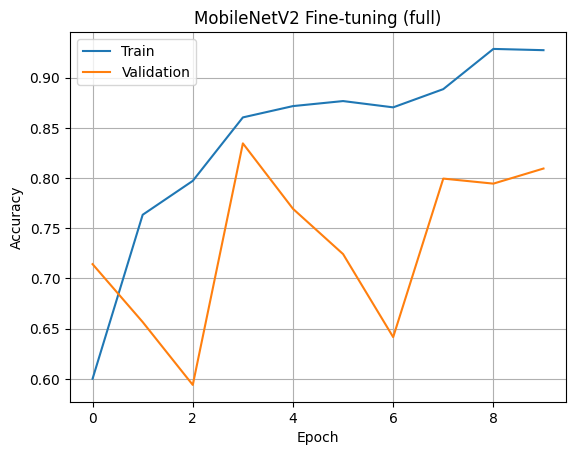

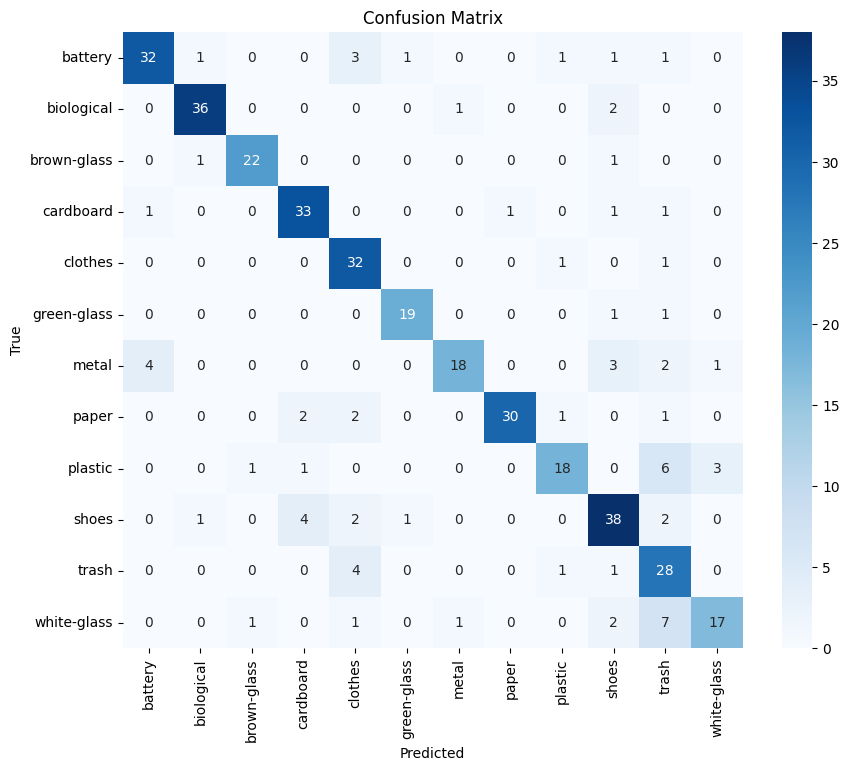

Classification Report:
              precision    recall  f1-score   support

     battery       0.86      0.80      0.83        40
  biological       0.92      0.92      0.92        39
 brown-glass       0.92      0.92      0.92        24
   cardboard       0.82      0.89      0.86        37
     clothes       0.73      0.94      0.82        34
 green-glass       0.90      0.90      0.90        21
       metal       0.90      0.64      0.75        28
       paper       0.97      0.83      0.90        36
     plastic       0.82      0.62      0.71        29
       shoes       0.76      0.79      0.78        48
       trash       0.56      0.82      0.67        34
 white-glass       0.81      0.59      0.68        29

    accuracy                           0.81       399
   macro avg       0.83      0.81      0.81       399
weighted avg       0.83      0.81      0.81       399



In [4]:
# Exp.3.5 - Transfer Learning Fine-tuning (full) - small data

import torch
import torch.nn as nn
from torchvision.models import mobilenet_v2, MobileNet_V2_Weights
from sklearn.metrics import classification_report

# 1) 모델 정의 (pretrained + custom head)
class CustomMobileNetV2_exp3(nn.Module):
    def __init__(self, num_classes=12):
        super().__init__()
        base = mobilenet_v2(weights=MobileNet_V2_Weights.IMAGENET1K_V1)
        self.features = base.features                      # pretrained backbone
        self.pool = nn.AdaptiveAvgPool2d(1)                # GAP

        # ✨ custom classifier head
        self.classifier = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(1280, 256),
            nn.GELU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x


# 2) 파인튜닝 범위 설정 유틸
def set_finetune_mode(model: CustomMobileNetV2_exp3, mode="partial", unfreeze_last_blocks=2):
    """
    mode: 'freeze' | 'partial' | 'full'
    - freeze  : backbone 전부 freeze (feature extractor만 사용, head만 학습)
    - partial : backbone의 마지막 N개 블록만 학습
    - full    : backbone 전부 학습
    """
    # 일단 전부 freeze
    for p in model.features.parameters():
        p.requires_grad = False

    if mode == "full":
        for p in model.features.parameters():
            p.requires_grad = True

    elif mode == "partial":
        # mobilenet_v2.features 는 Sequential. 마지막 N개 블록만 unfreeze
        blocks = list(model.features.children())
        for m in blocks[-unfreeze_last_blocks:]:
            for p in m.parameters():
                p.requires_grad = True

    elif mode == "freeze":
        pass  # 이미 전부 freeze 상태

    else:
        raise ValueError("mode should be one of {'freeze','partial','full'}")


# 3) 옵티마이저: 백본/헤드에 서로 다른 LR
def build_optimizer(model, backbone_lr=1e-4, head_lr=1e-3, weight_decay=1e-4):
    backbone_params = [p for p in model.features.parameters() if p.requires_grad]
    head_params     = [p for p in model.classifier.parameters() if p.requires_grad]

    param_groups = []
    if len(backbone_params) > 0:
        param_groups.append({"params": backbone_params, "lr": backbone_lr})
    if len(head_params) > 0:
        param_groups.append({"params": head_params, "lr": head_lr})

    # AdamW 권장
    optimizer = torch.optim.AdamW(param_groups, weight_decay=weight_decay)
    return optimizer


# -----------------------------
# 4) 실제 실험 스크립트
# -----------------------------
# (1) 데이터
train_loader, val_loader, class_names = get_dataloaders(data_path, use_small=True)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# (2) 모델
model = CustomMobileNetV2_exp3(num_classes=12).to(device)

# (3) 파인튜닝 모드 선택
#   'freeze'  : feature extraction만
#   'partial' : 마지막 2개 블록만 학습 (epoch 10 조건에서 강추)
#   'full'    : 전체 학습
finetune_mode = "full"   # ← 실험마다 'freeze' / 'partial' / 'full' 바꿔서 비교
set_finetune_mode(model, mode=finetune_mode, unfreeze_last_blocks=2)

train_acc, val_acc = train_model(model, train_loader, val_loader, num_epochs=10, device=device)

# (7) Plot & Report
plot_accuracy(train_acc, val_acc, title=f"MobileNetV2 Fine-tuning ({finetune_mode})")

plot_confusion_matrix(model, val_loader, class_names, device=device)

all_preds, all_labels = [], []
model.eval()
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))


Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:01<00:00, 11.4MB/s]


Epoch [1/10] Train Acc: 78.50%, Val Acc: 91.26%
Epoch [2/10] Train Acc: 87.95%, Val Acc: 91.61%
Epoch [3/10] Train Acc: 88.71%, Val Acc: 92.51%
Epoch [4/10] Train Acc: 90.20%, Val Acc: 92.61%
Epoch [5/10] Train Acc: 90.96%, Val Acc: 92.46%
Epoch [6/10] Train Acc: 91.22%, Val Acc: 92.86%
Epoch [7/10] Train Acc: 91.90%, Val Acc: 93.21%
Epoch [8/10] Train Acc: 92.70%, Val Acc: 93.21%
Epoch [9/10] Train Acc: 93.28%, Val Acc: 91.21%
Epoch [10/10] Train Acc: 93.20%, Val Acc: 93.06%


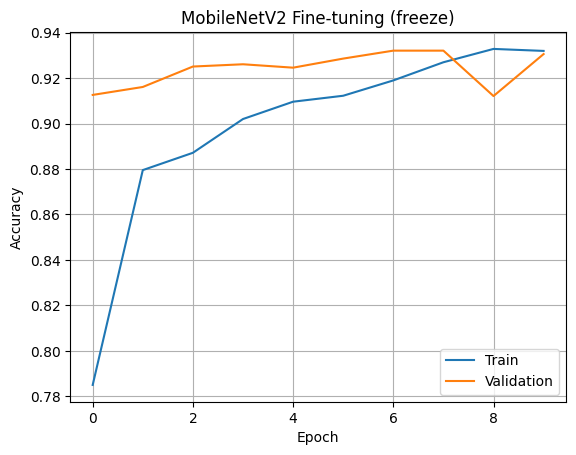

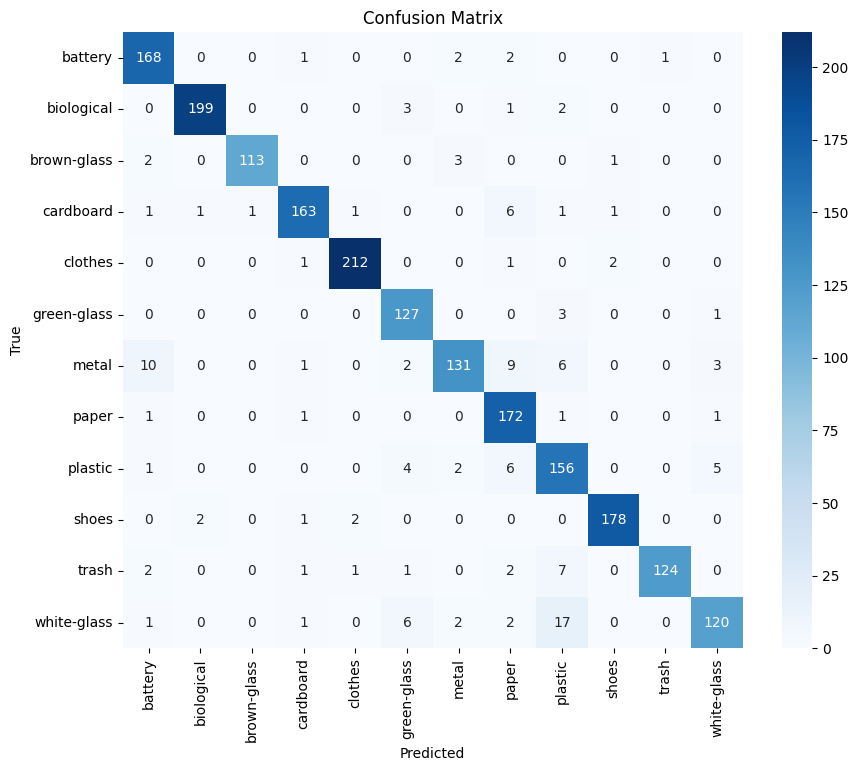

Classification Report:
              precision    recall  f1-score   support

     battery       0.90      0.97      0.93       174
  biological       0.99      0.97      0.98       205
 brown-glass       0.99      0.95      0.97       119
   cardboard       0.96      0.93      0.94       175
     clothes       0.98      0.98      0.98       216
 green-glass       0.89      0.97      0.93       131
       metal       0.94      0.81      0.87       162
       paper       0.86      0.98      0.91       176
     plastic       0.81      0.90      0.85       174
       shoes       0.98      0.97      0.98       183
       trash       0.99      0.90      0.94       138
 white-glass       0.92      0.81      0.86       149

    accuracy                           0.93      2002
   macro avg       0.93      0.93      0.93      2002
weighted avg       0.93      0.93      0.93      2002



In [2]:
# Exp.4 - Transfer Learning Fine-tuning (freeze) - 2h

import torch
import torch.nn as nn
from torchvision.models import mobilenet_v2, MobileNet_V2_Weights
from sklearn.metrics import classification_report

# 1) 모델 정의 (pretrained + custom head)
class CustomMobileNetV2_exp4(nn.Module):
    def __init__(self, num_classes=12):
        super().__init__()
        base = mobilenet_v2(weights=MobileNet_V2_Weights.IMAGENET1K_V1)
        self.features = base.features                      # pretrained backbone
        self.pool = nn.AdaptiveAvgPool2d(1)                # GAP

        # ✨ custom classifier head
        self.classifier = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(1280, 256),
            nn.GELU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x


# 2) 파인튜닝 범위 설정 유틸
def set_finetune_mode(model: CustomMobileNetV2_exp4, mode="partial", unfreeze_last_blocks=2):
    """
    mode: 'freeze' | 'partial' | 'full'
    - freeze  : backbone 전부 freeze (feature extractor만 사용, head만 학습)
    - partial : backbone의 마지막 N개 블록만 학습
    - full    : backbone 전부 학습
    """
    # 일단 전부 freeze
    for p in model.features.parameters():
        p.requires_grad = False

    if mode == "full":
        for p in model.features.parameters():
            p.requires_grad = True

    elif mode == "partial":
        # mobilenet_v2.features 는 Sequential. 마지막 N개 블록만 unfreeze
        blocks = list(model.features.children())
        for m in blocks[-unfreeze_last_blocks:]:
            for p in m.parameters():
                p.requires_grad = True

    elif mode == "freeze":
        pass  # 이미 전부 freeze 상태

    else:
        raise ValueError("mode should be one of {'freeze','partial','full'}")


# 3) 옵티마이저: 백본/헤드에 서로 다른 LR
def build_optimizer(model, backbone_lr=1e-4, head_lr=1e-3, weight_decay=1e-4):
    backbone_params = [p for p in model.features.parameters() if p.requires_grad]
    head_params     = [p for p in model.classifier.parameters() if p.requires_grad]

    param_groups = []
    if len(backbone_params) > 0:
        param_groups.append({"params": backbone_params, "lr": backbone_lr})
    if len(head_params) > 0:
        param_groups.append({"params": head_params, "lr": head_lr})

    # AdamW 권장
    optimizer = torch.optim.AdamW(param_groups, weight_decay=weight_decay)
    return optimizer


# -----------------------------
# 4) 실제 실험 스크립트
# -----------------------------
# (1) 데이터
train_loader, val_loader, class_names = get_dataloaders(data_path, use_small=False)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# (2) 모델
model = CustomMobileNetV2_exp4(num_classes=12).to(device)

# (3) 파인튜닝 모드 선택
#   'freeze'  : feature extraction만
#   'partial' : 마지막 2개 블록만 학습 (epoch 10 조건에서 강추)
#   'full'    : 전체 학습
finetune_mode = "freeze"   # ← 실험마다 'freeze' / 'partial' / 'full' 바꿔서 비교
set_finetune_mode(model, mode=finetune_mode, unfreeze_last_blocks=2)

train_acc, val_acc = train_model(model, train_loader, val_loader, num_epochs=10, device=device)

# (7) Plot & Report
plot_accuracy(train_acc, val_acc, title=f"MobileNetV2 Fine-tuning ({finetune_mode})")

plot_confusion_matrix(model, val_loader, class_names, device=device)

all_preds, all_labels = [], []
model.eval()
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))
